In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [5]:
df = pd.read_excel("erasmus_data.xlsx")
df

,student_id,university_name,seasons,score,condition
0,20011096,FONTYS HOGESCHOLEN,3,89.230,HİBELİ
1,19011501,HOCHSCHULE ESSLINGEN,3,88.500,HİBELİ
2,20011601,CESKÉ VYSOKÉ UCENÍ TECHNICKÉ V PRAZE,3,88.365,HİBELİ
3,18052083,LINNÉUNIVERSITETET,3,87.765,HİBELİ
4,18011012,POLITECHNIKA WARSZAWSKA,3,87.000,HİBELİ
...,...,...,...,...,...
8555,17011902,RIGAS TEHNISKA UNIVERSITATE,1,72.200,HİBESİZ
8556,15011084,LINNÉUNIVERSITETET,1,70.915,HİBESİZ
8557,15011703,POLITECHNIKA WARSZAWSKA,1,65.980,HİBESİZ
8558,15011064,UNIVERSIDAD DE GRANADA,1,61.000,HİBESİZ


In [6]:
ord_encoder = OrdinalEncoder()
condition_array = ord_encoder.fit_transform(df[["condition"]])
df_copy = df.copy()
df_copy["condition"] = condition_array
df_copy["condition"] = df_copy["condition"].astype(int) 

df_copy["condition"] = df_copy["condition"].replace(0, 2)
df_copy["condition"] = df_copy["condition"].replace(1, 0)
df_copy["condition"] = df_copy["condition"].replace(2, 1)

In [7]:
# having the student years
student_ids = df_copy.iloc[:, 0]
student_years = [int(str(student_id)[:2]) for student_id in student_ids]
df_copy["student_id"] = student_years

In [8]:
df_copy = df_copy.rename(columns = {"student_id":"student_starting_year"})
df_no_uni = df_copy.drop(columns = ["university_name"])
df_no_uni

,student_starting_year,seasons,score,condition
0,20,3,89.230,1
1,19,3,88.500,1
2,20,3,88.365,1
3,18,3,87.765,1
4,18,3,87.000,1
...,...,...,...,...
8555,17,1,72.200,0
8556,15,1,70.915,0
8557,15,1,65.980,0
8558,15,1,61.000,0


In [10]:
X_no_uni = df_no_uni.iloc[:, -2]
Y_no_uni = df_no_uni.iloc[:, -1]
X_no_uni

0       89.230
1       88.500
2       88.365
3       87.765
4       87.000
         ...  
8555    72.200
8556    70.915
8557    65.980
8558    61.000
8559    60.515
Name: score, Length: 8560, dtype: float64

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_no_uni, Y_no_uni, test_size=0.2, random_state=71)

In [15]:
scaler = MinMaxScaler()
# X_train["score"] = scaler.fit_transform(X_train[["score"]])
# X_test["score"] = scaler.transform(X_test[["score"]])
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

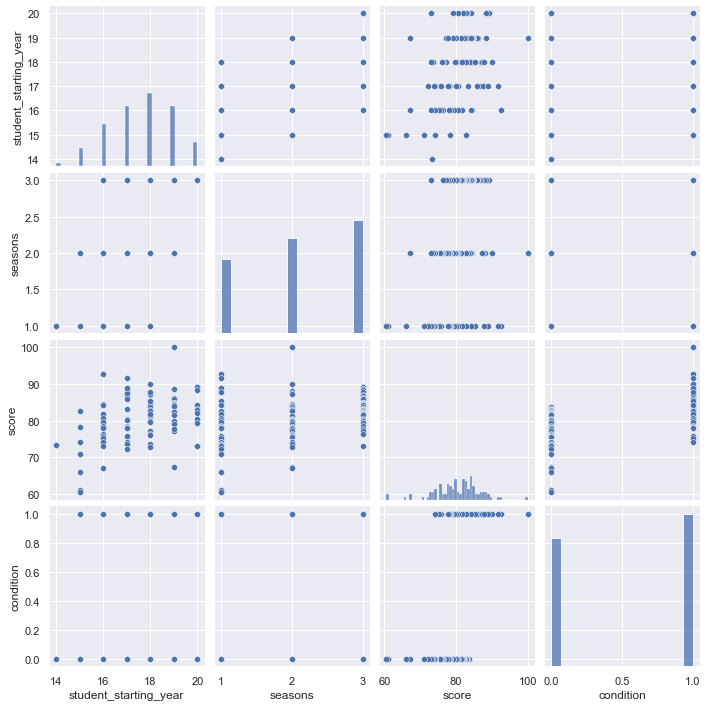

In [16]:
sns.set()
sns.pairplot(df_no_uni, height = 2.5)
plt.show()

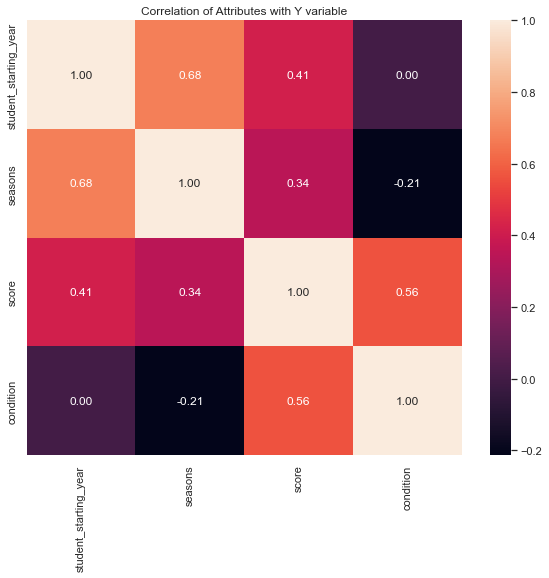

In [17]:
correlation = df_no_uni.corr()
plt.figure(figsize=(10, 8))
plt.title("Correlation of Attributes with Y variable")
plot = sns.heatmap(correlation, square=True, annot=True, fmt=".2f", linecolor="white")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_yticklabels(plot.get_yticklabels(), rotation=90)
plt.show()

In [57]:
def GridSearchCV_Results(model, parameters, x_train_data, y_train_data, cv=5, n_jobs=-1):
    gscv = GridSearchCV(model, parameters, cv=cv)
    gscv.fit(x_train_data, y_train_data)
    print("Best score: ", gscv.best_score_)
    print("Best params: ", gscv.best_params_)
    return gscv.best_estimator_

def Get_Scores(model, x_train_data, x_test_data, y_train_data, y_test_data):
    train_score = model.score(x_train_data, y_train_data)
    test_score = model.score(x_test_data, y_test_data)
    print("Train Score: ", train_score)
    print("Test Score: ", test_score)
    return (train_score,
           test_score)

def Final_Pred(model, col_names, prediction_data = np.array([[18, 4, 83.5]])):
    if isinstance(prediction_data, np.ndarray):
        pass
    elif isinstance(prediction_data, list):
        prediction_data = np.array(prediction_data)
    
    preds = model.predict(pd.DataFrame(prediction_data, columns=col_names[:-1]))
    probas = model.predict_proba(pd.DataFrame(prediction_data, columns=col_names[:-1]))
    preds_condition = ["HIBELI" if pred == 1 else "HIBESIZ" for pred in preds]
    
    result = [np.append(base, pred) for base, pred in list(zip(prediction_data, preds_condition))]
    result = pd.DataFrame(result, columns=col_names)
    print("\n Result:\n", result.to_string(index=False))
    
    return (preds, preds_condition)

In [55]:
def machine_learning_results(pred_data, X_train, X_test, Y_train, Y_test):
    models_and_params = {
        "KNN": {
            "model": KNeighborsClassifier(),
            "cv_params": {"n_neighbors": np.arange(2, 50)}
        },

        "SVC RBF": {
            "model": SVC(),
            "cv_params": {
                      'gamma': ['auto', 0.001, 0.01, 0.1],
                      'C': np.linspace(0.0001, 100, 5),
                      'kernel':["rbf"],
                      'probability':[True]
                   }
        },

        "SVC Linear": {
            "model": SVC(),
            "cv_params": {
                      'C': [0.01, 0.1, 1],
                      'kernel':["linear"],
                      'probability':[True]
                   }
        },

        "LogisticRegression": {
            "model": LogisticRegression(max_iter=200),
            "cv_params": {"C": np.logspace(-3, 3, 7), "penalty":["l1", "l2"]}
        }
    }

    for model_name, params in models_and_params.items():
        print("---Model: ", model_name)
        model = params["model"]
        cv_params = params["cv_params"]
        
        X_train = X_train[:]
        X_test = X_test[:]
        
        if not isinstance(X_train, np.ndarray):
            X_train = np.array(X_train)
        try: 
            X_train.shape[1]
        except IndexError:
            X_train = X_train.reshape(-1, 1)
            
        if not isinstance(X_test, np.ndarray):
            X_test = np.array(X_test)
        try: 
            X_test.shape[1]
        except IndexError:
            X_test = X_test.reshape(-1, 1)

        best_model = GridSearchCV_Results(model, cv_params, X_train, Y_train, 5, -1)
        best_model.fit(X_train, Y_train)
        print(best_model)
        train_score, test_score = Get_Scores(best_model, X_train, X_test, Y_train, Y_test)
        
        if isinstance(X_train, pd.DataFrame):
            col_names = X_train.colums[-2:]
        else:
            col_names = ["Score", "Condition"]
            
        prediction, pred_condition = Final_Pred(best_model, col_names, pred_data)


In [20]:
my_score = lambda agno, lang_exam: (agno * 25 / 2) + lang_exam / 2

In [25]:
## Neural Network 
# 3 input 1 output
inputs = keras.Input(shape=(1))

x = layers.Dense(2, activation="relu", kernel_initializer="glorot_uniform")(inputs)
outputs = layers.Dense(1, activation="sigmoid", kernel_initializer="glorot_uniform")(x)

nn_model = keras.Model(inputs=inputs, outputs=outputs, name="erasmus_hibeli_hibesiz_model")

In [26]:
nn_model.summary()

Model: "erasmus_hibeli_hibesiz_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [27]:
nn_model.compile(optimizer="adam",
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=["accuracy"])

In [28]:
nn_model.fit(X_train.values, Y_train.values, epochs=11)

Epoch 1/11
214/214 [==============================] - 1s 2ms/step - loss: 0.7369 - accuracy: 0.5320
Epoch 2/11
214/214 [==============================] - 0s 2ms/step - loss: 0.6853 - accuracy: 0.5412
Epoch 3/11
214/214 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5415
Epoch 4/11
214/214 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.5480
Epoch 5/11
214/214 [==============================] - 0s 2ms/step - loss: 0.6817 - accuracy: 0.5402
Epoch 6/11
214/214 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.5508
Epoch 7/11
214/214 [==============================] - 0s 2ms/step - loss: 0.6773 - accuracy: 0.5510
Epoch 8/11
214/214 [==============================] - 0s 2ms/step - loss: 0.6743 - accuracy: 0.5625
Epoch 9/11
214/214 [==============================] - 0s 2ms/step - loss: 0.6721 - accuracy: 0.5724
Epoch 10/11
214/214 [==============================] - 0s 2ms/step - loss: 0.6706 - accuracy: 0.5678

In [29]:
test_loss, test_acc = nn_model.evaluate(X_test, Y_test, verbose=2)
print("\nTest accuracy:", test_acc)

54/54 - 0s - loss: 0.6626 - accuracy: 0.5754 - 361ms/epoch - 7ms/step

Test accuracy: 0.5753504633903503


In [30]:
possible_scores = [
    [18, 4, my_score(3.08, 0)],
    [18, 4, my_score(3.08, 10)],
    [18, 4, my_score(3.08, 20)],
    [18, 4, my_score(3.08, 30)],
    [18, 4, my_score(3.08, 40)],
    [18, 4, my_score(3.08, 50)],
    [18, 4, my_score(3.08, 60)],
    [18, 4, my_score(3.08, 70)],
    [18, 4, my_score(3.08, 80)],
    [18, 4, my_score(3.08, 90)],
    [18, 4, my_score(3.08, 92)],
    [18, 4, my_score(3.08, 94)],
    [18, 4, my_score(3.08, 96)],
    [18, 4, my_score(3.08, 98)],
    [18, 4, my_score(3.08, 100)],
]
possible_scores = [_score[-1] for _score in possible_scores]
possible_scores = np.array(possible_scores)
possible_scores.shape

(15,)

In [37]:
predictions = nn_model.predict(possible_scores)
predictions = ["HIBELI" if pred > 0.5 else "HIBESIZ" for pred in predictions]
result = [np.append(base, pred) for base, pred in list(zip(possible_scores, predictions))]
# result = pd.DataFrame(result, columns=["Student Id Year", "|Season", "|Erasmus Score", "|Going Condition"])
result = pd.DataFrame(result, columns=["|Erasmus Score", "|Going Condition"])
result

,|Erasmus Score,|Going Condition
0,38.5,HIBESIZ
1,43.5,HIBESIZ
2,48.5,HIBESIZ
3,53.5,HIBESIZ
4,58.5,HIBESIZ
5,63.5,HIBESIZ
6,68.5,HIBELI
7,73.5,HIBELI
8,78.5,HIBELI
9,83.5,HIBELI


In [58]:
print("\nBasic Neural Network Result:\n", result.to_string(index=False))
print("nMachine Learning Results:")
machine_learning_results(possible_scores, X_train, X_test, Y_train, Y_test)



Basic Neural Network Result:
 |Erasmus Score |Going Condition
          38.5          HIBESIZ
          43.5          HIBESIZ
          48.5          HIBESIZ
          53.5          HIBESIZ
          58.5          HIBESIZ
          63.5          HIBESIZ
          68.5           HIBELI
          73.5           HIBELI
          78.5           HIBELI
          83.5           HIBELI
          84.5           HIBELI
          85.5           HIBELI
          86.5           HIBELI
          87.5           HIBELI
          88.5           HIBELI
'nMachine Learning Results:'
---Model:  KNN
Best score:  0.9707962016070123
Best params:  {'n_neighbors': 2}
KNeighborsClassifier(n_neighbors=2)
Train Score:  0.9721086448598131
Test Score:  0.9713785046728972

 Result:
 Score Condition
 38.5   HIBESIZ
 43.5   HIBESIZ
 48.5   HIBESIZ
 53.5   HIBESIZ
 58.5   HIBESIZ
 63.5   HIBESIZ
 68.5   HIBESIZ
 73.5   HIBESIZ
 78.5   HIBESIZ
 83.5   HIBESIZ
 84.5    HIBELI
 85.5    HIBELI
 86.5    HIBELI
 87.5    HIB

C:\Users\semih\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\semih\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Best score:  0.8694553539532824
Best params:  {'C': 100.0, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
SVC(C=100.0, gamma='auto', probability=True)
Train Score:  0.8694509345794392
Test Score:  0.8679906542056075

 Result:
 Score Condition
 38.5   HIBESIZ
 43.5   HIBESIZ
 48.5   HIBESIZ
 53.5   HIBESIZ
 58.5   HIBESIZ
 63.5   HIBESIZ
 68.5   HIBESIZ
 73.5   HIBESIZ
 78.5    HIBELI
 83.5   HIBESIZ
 84.5    HIBELI
 85.5    HIBELI
 86.5    HIBELI
 87.5    HIBELI
 88.5    HIBELI
---Model:  SVC Linear


C:\Users\semih\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\semih\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Best score:  0.6990367522780228
Best params:  {'C': 1, 'kernel': 'linear', 'probability': True}
SVC(C=1, kernel='linear', probability=True)
Train Score:  0.6990362149532711
Test Score:  0.7085280373831776

 Result:
 Score Condition
 38.5   HIBESIZ
 43.5   HIBESIZ
 48.5   HIBESIZ
 53.5   HIBESIZ
 58.5   HIBESIZ
 63.5   HIBESIZ
 68.5   HIBESIZ
 73.5   HIBESIZ
 78.5   HIBESIZ
 83.5    HIBELI
 84.5    HIBELI
 85.5    HIBELI
 86.5    HIBELI
 87.5    HIBELI
 88.5    HIBELI
---Model:  LogisticRegression


C:\Users\semih\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\semih\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Best score:  0.706921456868192
Best params:  {'C': 0.001, 'penalty': 'l2'}
LogisticRegression(C=0.001, max_iter=200)
Train Score:  0.7083820093457944
Test Score:  0.717873831775701

 Result:
 Score Condition
 38.5   HIBESIZ
 43.5   HIBESIZ
 48.5   HIBESIZ
 53.5   HIBESIZ
 58.5   HIBESIZ
 63.5   HIBESIZ
 68.5   HIBESIZ
 73.5   HIBESIZ
 78.5   HIBESIZ
 83.5    HIBELI
 84.5    HIBELI
 85.5    HIBELI
 86.5    HIBELI
 87.5    HIBELI
 88.5    HIBELI


C:\Users\semih\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\semih\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\semih\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\semih\AppData\Local\Programs\Python\